# Lecture 14 - Advanced Curve Fitting: Multivariate Gaussian Process Regression and Automatic Relevance Determination

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

## Objectives

+ To demonstrate GP regression with multiple inputs.
+ To highlight how GP regression does automatic relevance determination.
+ To discuss the curse of dimensionality in the context of GP regression and some ways of dealing with it (active subspaces and high-dimensional model representation).

## Readings

+

## Multivariate Gaussian Process Regression

When we say "multivariate" here we refer to many function inputs, not outputs.
This just means that the input of the function we are interested in learning is a vector $\mathbf{x}$ in $\mathbb{R}^D$.
In that regard, nothing really changes compared to one-input GPR.
The formulas are exactly the same.
However, in higher dimensional settings one must pay attention to the selection of the covariance function.

Let's demonstrate this using an example.
Here is an analytical function, known as the Branin-Hoo function:
$$
f(\mathbf{x}) = f(x_1,x_2) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right]
$$
We will use this function to generate some synthetic data.
Let's superimpose the synthetic data on a contour of this function.

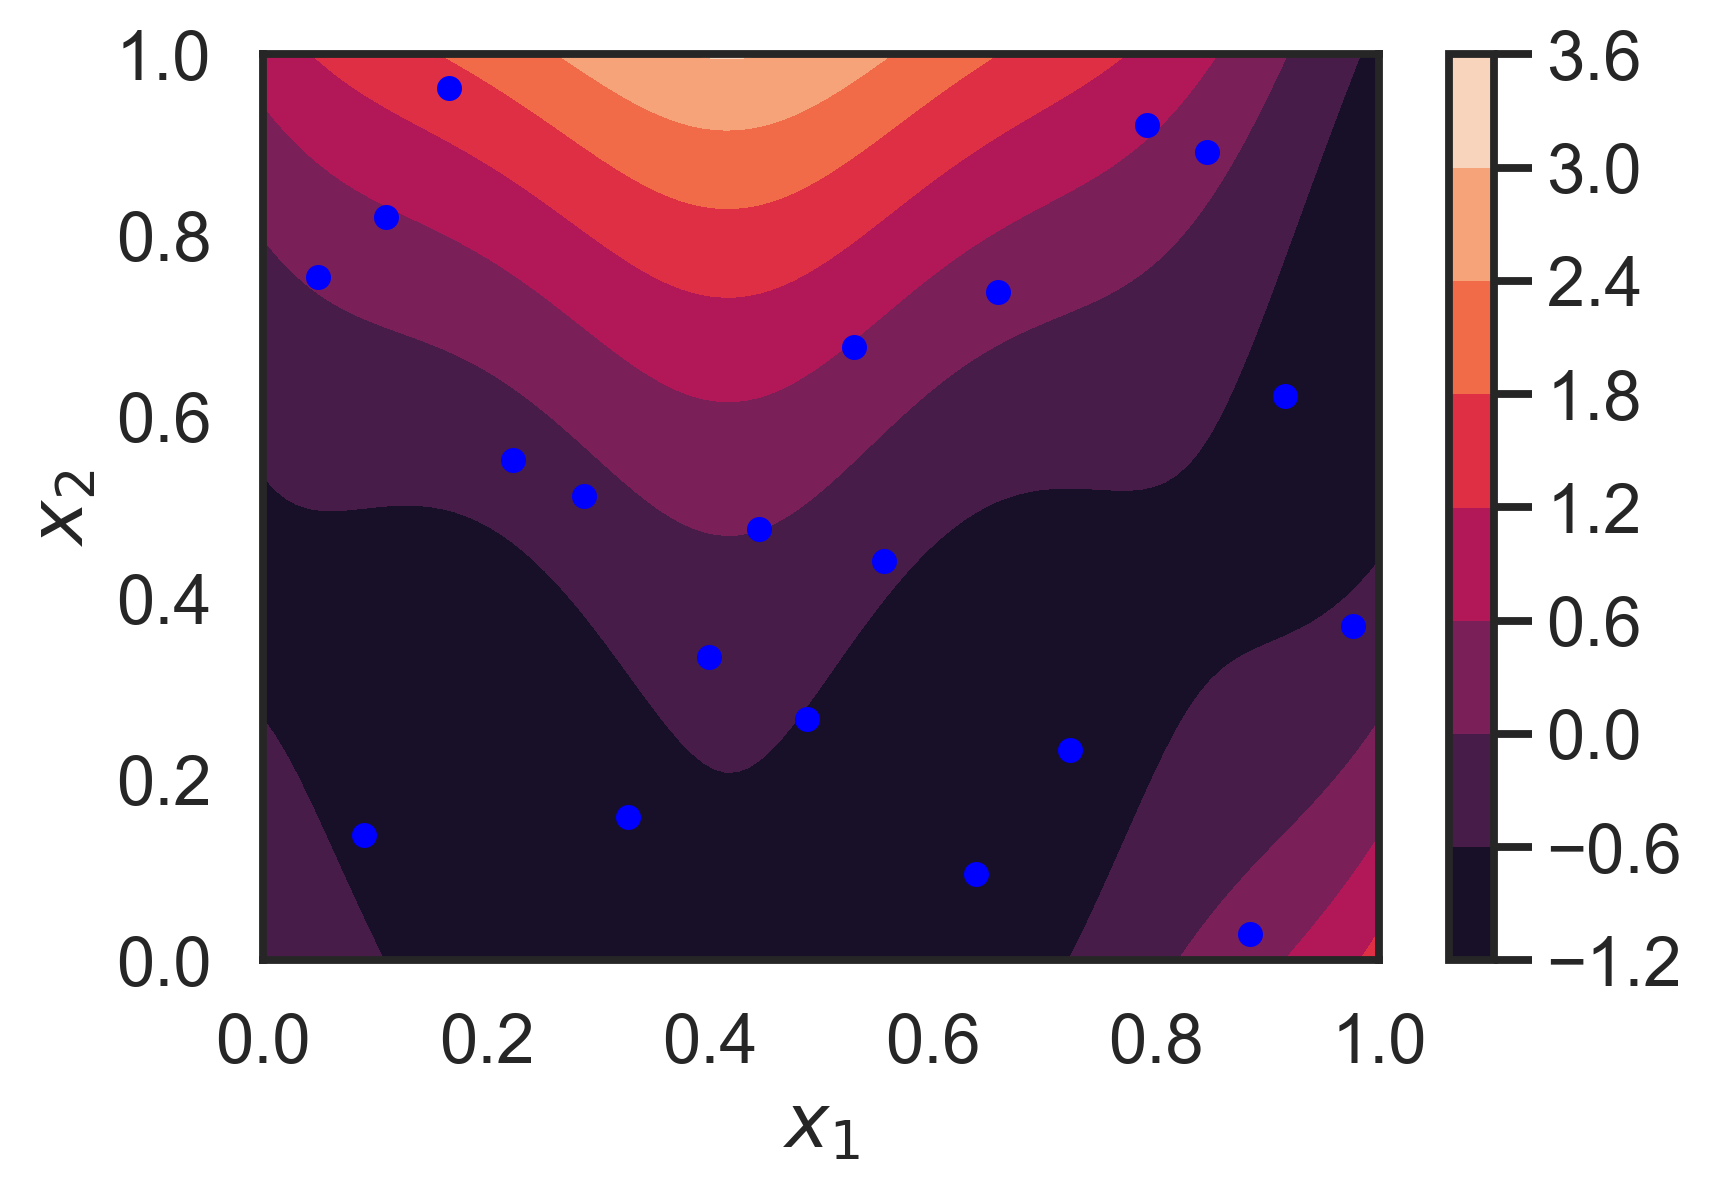

In [2]:
# Define the function
def f_branin(x):
    """
    Input must be 2D array of size N x 2.
    """
    return 1.0 / 51.95 * ((15.0 * x[:, 1] - 5.1 * (15.0 * x[:, 0]) ** 2 / 4.0 / np.pi ** 2 + 
                          75.0 * x[:, 0] / np.pi - 6.0) ** 2
                         + (10.0 - 10.0 / 8.0 / np.pi) * np.cos(15.0 * x[:, 0]) - 44.81)

# Generate synthetic data
n = 20
# Always use Latin-hypercube sampling when you get to pick the data
import pyDOE
X = pyDOE.lhs(2, n)
# We will also be adding a little bit of noise to the observations
sigma = 0.01
y = f_branin(X)[:, None] + sigma * np.random.randn(n, 1)

# Plot the contour and the observations
fig, ax = plt.subplots(dpi=300)
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_star_flat = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
Z_true = f_branin(X_star_flat).reshape(X1.shape)
c = ax.contourf(X1, X2, Z_true)
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
plt.colorbar(c)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

We will be using a the squared exponential covariance function for a regression along with a zero mean.
So our prior GP is:
$$
f(\cdot)\sim\operatorname{GP}(0, k(\cdot,\cdot)),
$$
with
$$
k(\mathbf{x}, \mathbf{x}') = s^2\exp\left(-\frac{(x_1-x_1')^2}{2\ell_1}-\frac{(x_2-x_2')^2}{2\ell_2}\right).
$$
The first, situation we are going to examin is when the lengthscales are the same:
$$
\ell_1 = \ell_2.
$$
This is what you get by default from ``GPy``:

In [3]:
import GPy
k = GPy.kern.RBF(2) # The 2 here is for the dimensionality of the input space
gp = GPy.models.GPRegression(X, y, k)
print(gp)


Name : GP regression
Objective : 23.463068396304287
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [112]:
gp.optimize_restarts(messages=True);

Optimization restart 1/10, f = 8.602453072026288


Optimization restart 2/10, f = 8.602453072019152


Optimization restart 3/10, f = 8.602453072019474


Optimization restart 4/10, f = 8.602453072017795


Optimization restart 5/10, f = 8.602453072017727


Optimization restart 6/10, f = 8.602453072018118


Optimization restart 7/10, f = 8.602453072017605


Optimization restart 8/10, f = 8.602453072211304


Optimization restart 9/10, f = 8.602453072017981


Optimization restart 10/10, f = 8.602453072017527


In [4]:
print(gp)
print(gp.kern.lengthscale)


Name : GP regression
Objective : 23.463068396304287
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     1.00000000  |      +ve      |        


NameError: name 'Z' is not defined

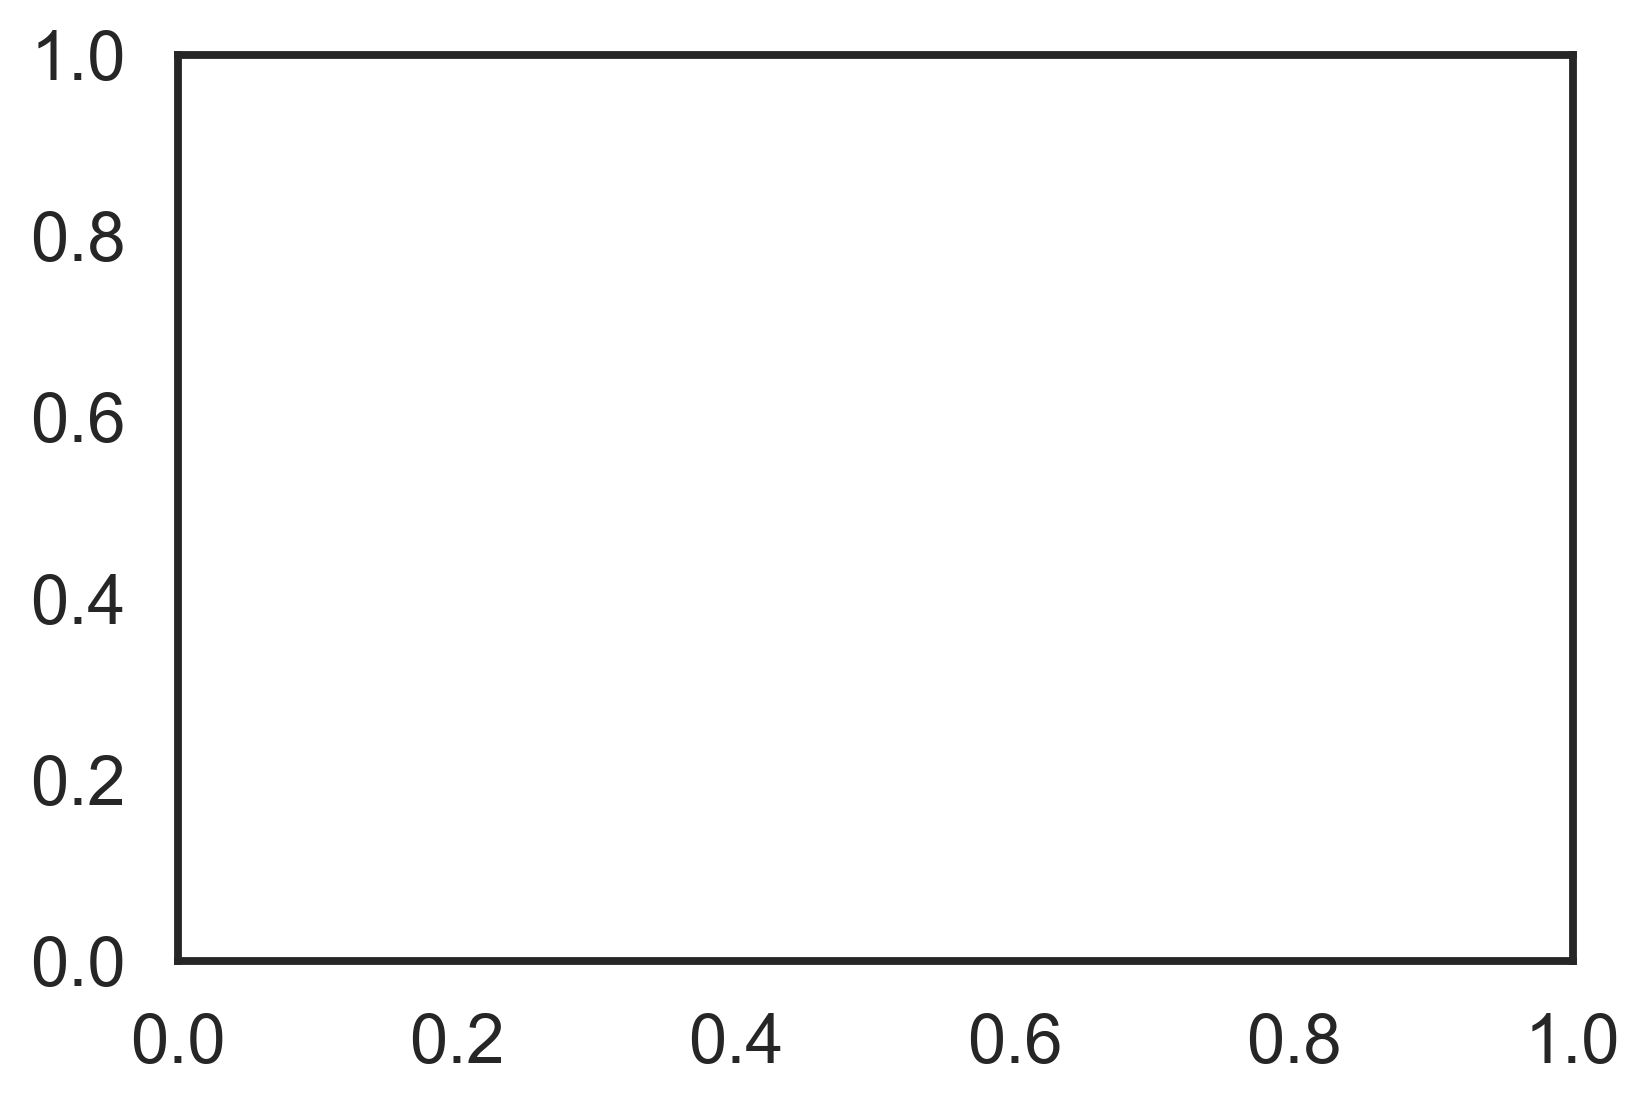

In [5]:
# Make predictions
z_flat, v_flat = gp.predict(X_star_flat)

# Contour of Predictions (Compare to contour of true values above)
fig, ax = plt.subplots(dpi=300)
Z_star = z_flat[:, 0].reshape(X1.shape)
c = ax.contourf(X1, X2, Z)
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
plt.colorbar(c)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# Let's also plot the contour of the error
fig, ax = plt.subplots(dpi=300)
E = np.abs(Z_true - Z_star)
c = ax.contourf(X1, X2, E)
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
plt.colorbar(c)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# And let's compare the error plot to 2 x the predictive standard deviation
fig, ax = plt.subplots(dpi=300)
c = ax.contourf(X1, X2, 2.0 * np.sqrt(v_flat.reshape(X1.shape)))
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
plt.colorbar(c)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

Now let's repeat the same analysis but allowing for a different lengthscale per input.
First, we set up and train the model:

In [117]:
import GPy
k = GPy.kern.RBF(2, ARD=True) # The ARD = True is what makes GPy understand that there is
                              # one lengthscale per dimension
gp = GPy.models.GPRegression(X, y, k)
print(gp)


Name : GP regression
Objective : 25.759857170678746
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (2,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Note that you now cannot see what the lengthscale values are.
You need to do this to see them:

In [119]:
print(gp.rbf.lengthscale)

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     1.00000000  |      +ve      |        
  [1]    |                     1.00000000  |      +ve      |        


And you can train the model as usual:

In [120]:
gp.optimize_restarts(); # No messages shown here
print(gp)
print(gp.rbf.lengthscale)

Optimization restart 1/10, f = 8.602453072026288
Optimization restart 2/10, f = 8.602453072027018
Optimization restart 3/10, f = 8.602453072044336
Optimization restart 4/10, f = 8.602453072023946
Optimization restart 5/10, f = 8.602453072025657
Optimization restart 6/10, f = 8.602453072019179
Optimization restart 7/10, f = 8.602453072047771
Optimization restart 8/10, f = 8.602453072022849
Optimization restart 9/10, f = 8.602453072085046
Optimization restart 10/10, f = 8.602453072018188

Name : GP regression
Objective : 8.602453072018188
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    1.3696081694832418  |      +ve      |        
  rbf.lengthscale          |                  (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.020860882321583486  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale  |  constrain

So, you se that the lengthscale assigned to $x_1$ is slightly bigger than the lengthscale assigned to $x_2$. This means that the first input is slightly more important than the second input.
This is the automatic relevance determination (ARD) in action.

**ROHIT:**
+ Expand Branin function with a third variable with mild linear dependence, say $+10x_3$. Demonstrate the ARD picks this up.
+ Expand Branin function with a fourth variable that is not used at all.
+ Add questions on ARD.
+ Explain active subspaces (without any of the theory - just the structure of the function).
+ Use a covariance function like this:
$k(\mathbf{x},\mathbf{x}') = s^2 \exp\left\{-\frac{1}{2}(\mathbf{x}-\mathbf{x}')^T\mathbf{A^T}\mathbf{A}(\mathbf{x}-\mathbf{x}')\right\},$ where the matrix $\mathbf{A}$ in $\mathbb{R}^{d\times D}$ has to be determined by maximum likelihood.
+ Apply this to a toy example.
+ Apply this to Constantine's example and data.
+ Show an example (maybe as a question) that does not have an active subspace, e.g., $f(\mathbf{x}) = \parallel \mathbf{x}\parallel$.
+ Add questions.
+ Write about high-dimensional model representation (or functional analysis of variance).
+ Demonstrate in relatively low dimensions how HDMR it can be modeled within GPy.
+ If possible, do a synthetic high-dimensional problem.
+ If possible, apply to Constantine's problem (not sure if it will work).
+ If possible, show an example where it does not work.